---------------------------------------------------------------------------------------------------------------------------
This tutorial relies on the example model provided by `wasar`, which is built from real public datasets belonging to a small area near the Doñana National Park (southern Spain). The model can be accessed directly through  `wasar.example.get_model()` and the relative paths to the data, through `wasar.example.get_path()`.
For more information about the data sources, see the file *Data Sources.txt*, located in the same folder as this tutorial.

Fore **more information** about the use of any function, method, class o moduel, use `help` bult-in (or `?`) to acces its documentation:

`>>> help(wasar.parts)` or press the **tabulator** key in Jupyter Notebook to access an object's methods.

---------------------------------------------------------------------------------------------------------------------------

<h1><center>Adding other database to the model</center></h1>

In this tutorial we will see how to **isnert a database** of other nature (non piezometry or rainfall types) through the `DataBase` class and how to use **`find_element`** methods, available for all parts. The DataBase will be randomnly created, so it will be different each time this sript is executed.

In [1]:
import wasar

## Creation of a random database
This database will act as a database formed by a set of GPS stations measuring in-situ ground deformation.

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd 
import numpy as np

import random

asc_fname = wasar.example.get_path('sentinel-Asc')
Asc = wasar.Dataset(asc_fname, name='Asc', color='#6E3CD1', units='cm')

x1, y1, x2, y2 = Asc.gdf.total_bounds  # Database geographical limits
random_point = lambda x1, y1, x2, y2 : Point(random.uniform(x1, x2), random.uniform(y1, y2))

NameError: name 'wasar' is not defined

In [10]:
import wasar

wasar

In [ ]:
# Records creation (pandas.DataFrame):
columns, values = [i for i in 'ABCDE'], [np.random.random(60) for i in range(5)]
df_table = {i:j for i,j in zip(columns, values)}
df = pd.DataFrame(df_table, index=pd.date_range(start='2015', end='2020', freq='M'))
df = df.melt(var_name='Nombre', value_name='Valores', ignore_index=False)
df.index.name = 'Fechas'
df.reset_index(inplace=True)

In [ ]:
# Spatial information creation (geopandas.GeoDataFrame)
table = {'Nombre':[i for i in 'ABCDE'],
         'geometry':[random_point(x1, y1, x2, y2) for i in range(5)]}
gdf = gpd.GeoDataFrame(table, crs=25830)

In [ ]:
# Creating DataBase part and adding spatial info.
Gps = wasar.DataBase(df, name='gps', units='cm', color='black')
Gps.append_geometry(gdf)

In [ ]:
Gps.plot(['A','B'], title='Visualizing some GPS stations')

## Using `find_element` method with the GPS database.

Here it is shown an **example of study** of the average deformation existing 10 km around *A* GPS station.

First of all let's see on a **map** the PS of Dataset 'Asc' and the available GPS stations.

In [7]:
mymap = Gps.mapa(LayerControl=False)
Asc.mapa(m=mymap)

To select the PS, it is necessary to include the **coordinates** of the sensor 'A', which I obtain from the **`xy`** method, available for any part.

In [2]:
A_xy = Gps.xy('A')

NameError: name 'Gps' is not defined

Now I use **`find_element`** method of the `Asc` Dataset to select the points within a range of 10 km from station `A` (`radius` can be changed if no close PS are found). As I am interested in the name of the points and not in their time series, I use the `columns` method of the `DataFrame` obtained.

In [9]:
points = Asc.find_element(A_xy, way='radius', radius=10).columns

I perform a `subset` with the points obtained to calculate their **average deformation time series**, taking into account only the **vertical component** of the deformation.

In [21]:
Asc_subset = Asc.subset(list(points), vm=True)
ts_Asc = Asc_subset.mean()

ts_gps = Gps.take('A').loc[:,('Fechas', 'Valores')]
ts_gps = ts_gps.set_index('Fechas').squeeze()   # I squeeze the output DataFrame to turn it into a Series

**Joint display** of both temporal series through the `plot` function of `Dataset`.

<AxesSubplot:title={'center':'GPS and closest Asc-Sentinel PS'}, xlabel='Fechas', ylabel='Deformación (cm)'>

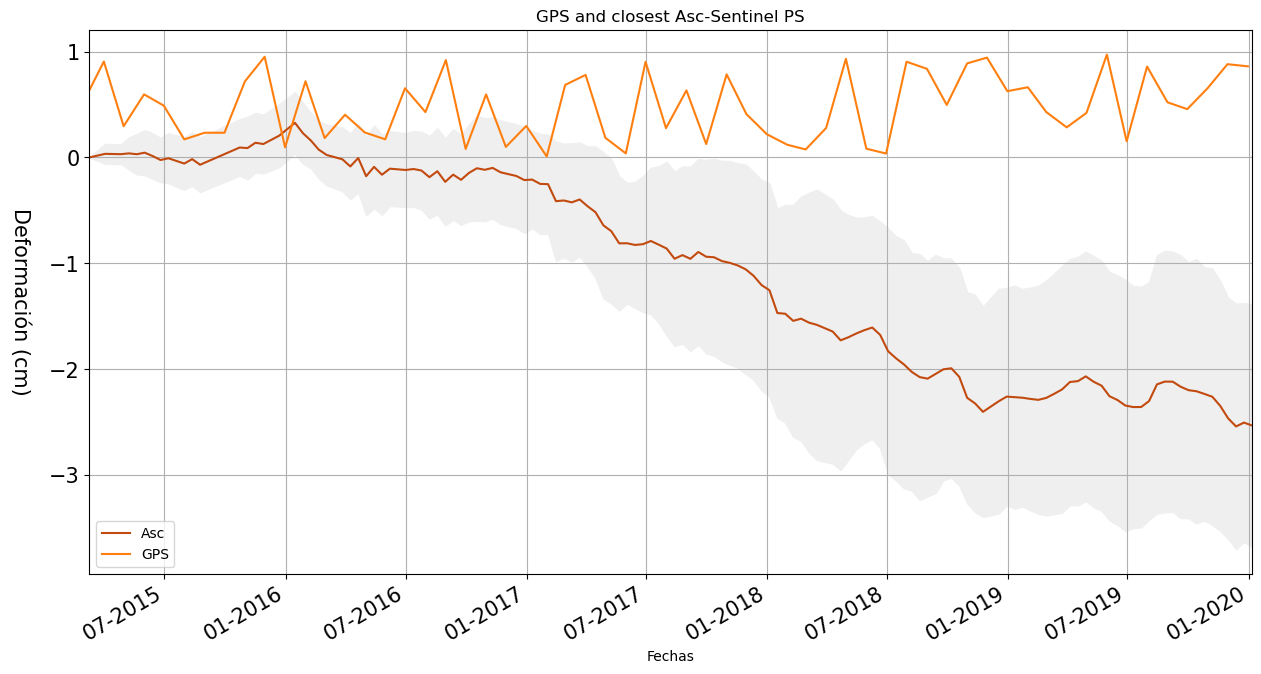

In [16]:
ax = Asc_subset.plot(mean=True, label='Asc', legend=True)
ts_gps.plot(ax=ax, label='GPS', legend=True, title='GPS and closest Asc-Sentinel PS')

Finally, we can combine both series in a **wavelet analysis** to jointly study the common periodicities. This will be done with a **monthly** sampling interval since it is the minimum common frequency.

Smoothing the time series...
Starting wavelet transformation and coherency computation...
... and simulations... 
  |======================================================================| 100%
Class attributes are accessible through following names:
series loess.span dt dj Wave.xy Angle sWave.xy sAngle Power.xy Power.xy.avg Power.xy.pval Power.xy.avg.pval Coherency Coherence Coherence.avg Coherence.pval Coherence.avg.pval Wave.x Wave.y Phase.x Phase.y Ampl.x Ampl.y Power.x Power.y Power.x.avg Power.y.avg Power.x.pval Power.y.pval Power.x.avg.pval Power.y.avg.pval sPower.x sPower.y Ridge.xy Ridge.co Ridge.x Ridge.y Period Scale nc nr coi.1 coi.2 axis.1 axis.2 date.format date.tz 


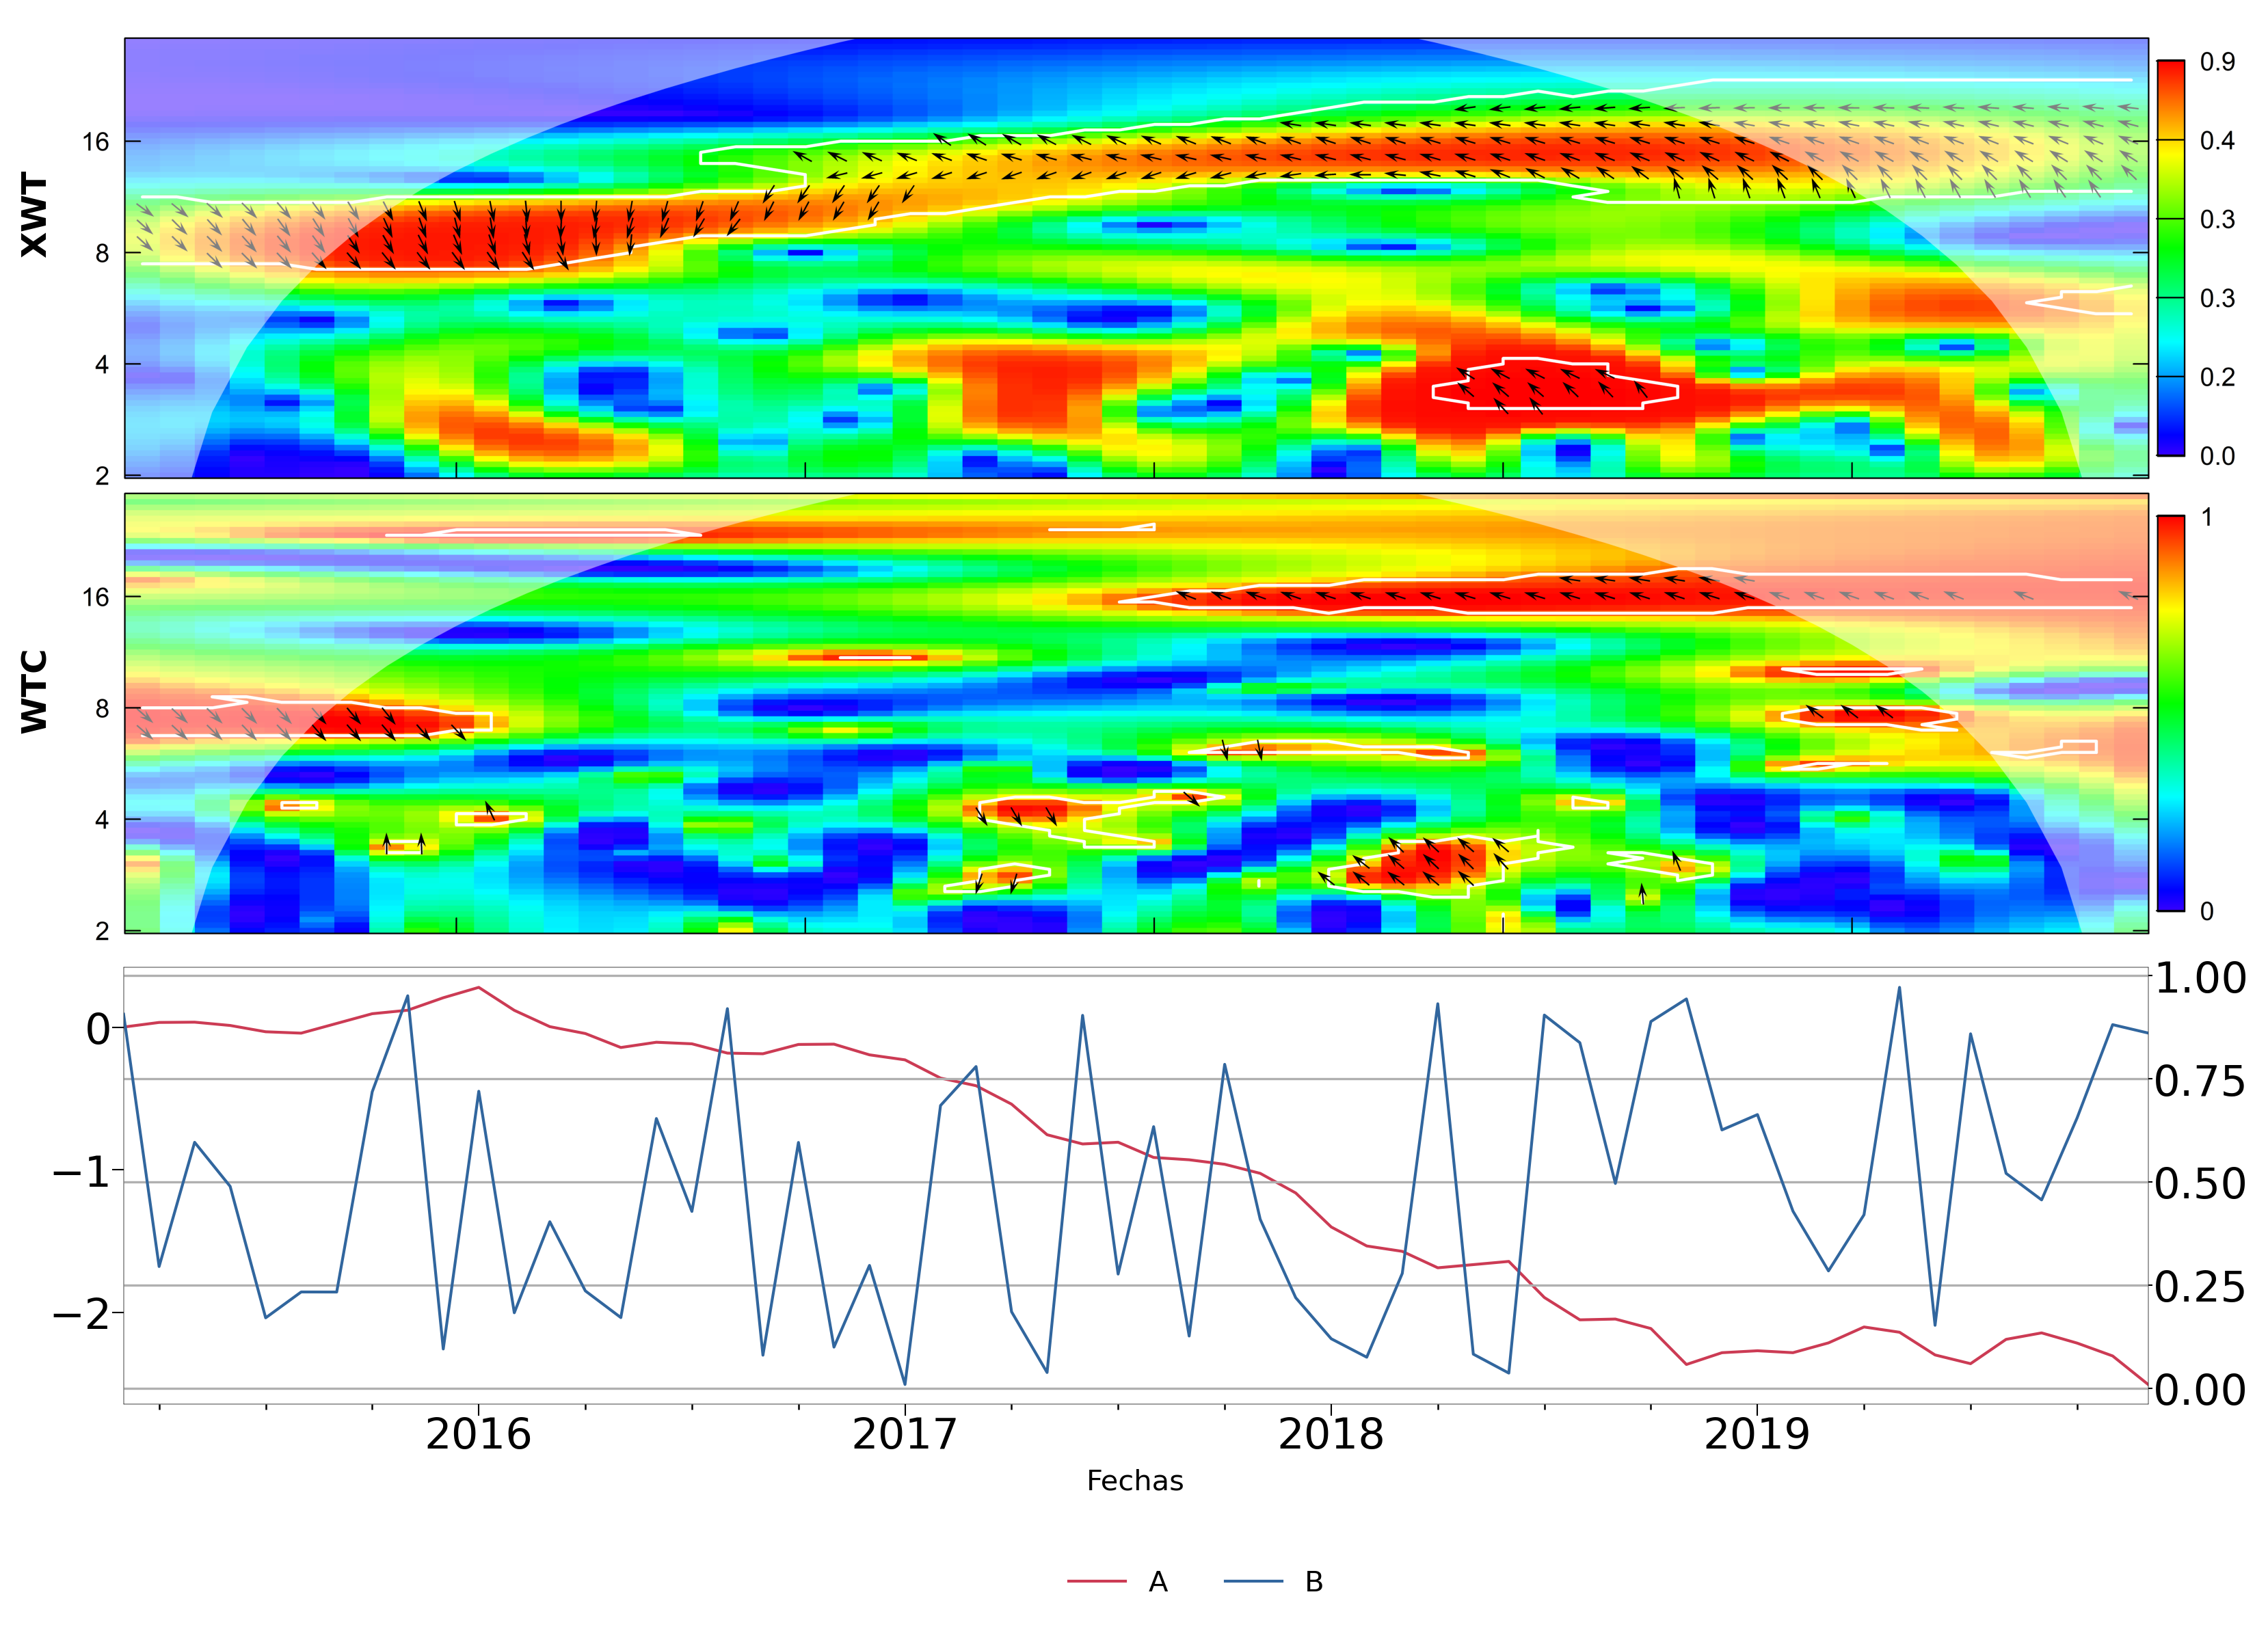

In [20]:
wasar.Wavelet('M', ts_Asc, ts_gps, dt=1, dj=1/20, UpperPeriod=2, LowerPeriod=30)